Enter DAILY tweets CSV path:  D:\Project\Project_II_PGDM_AIDS_33\Tweets_29Mar_Test_FIXED.csv
Enter tweet text to evaluate:  Not fully convinced by the recent decisions. More clarity and transparency are needed.


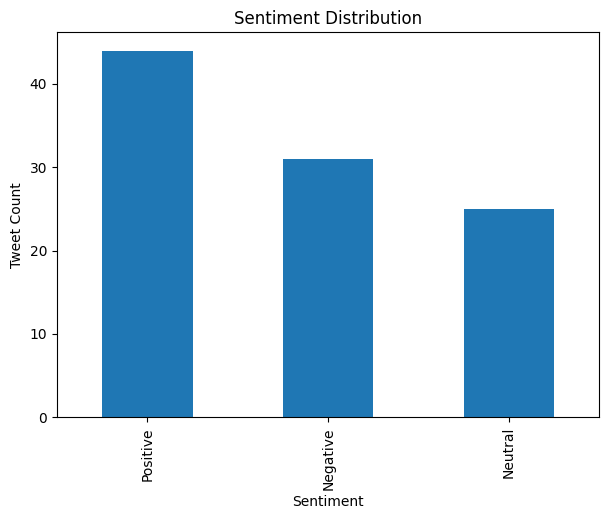

<Figure size 1000x600 with 0 Axes>

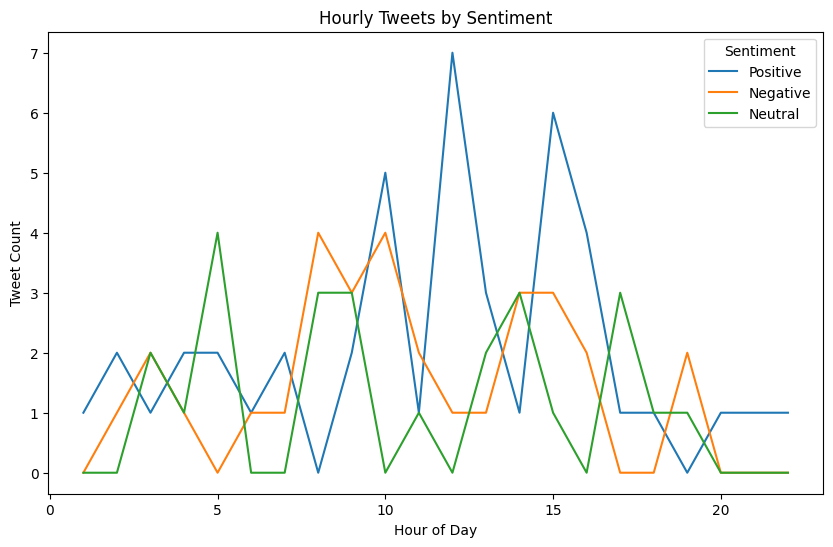

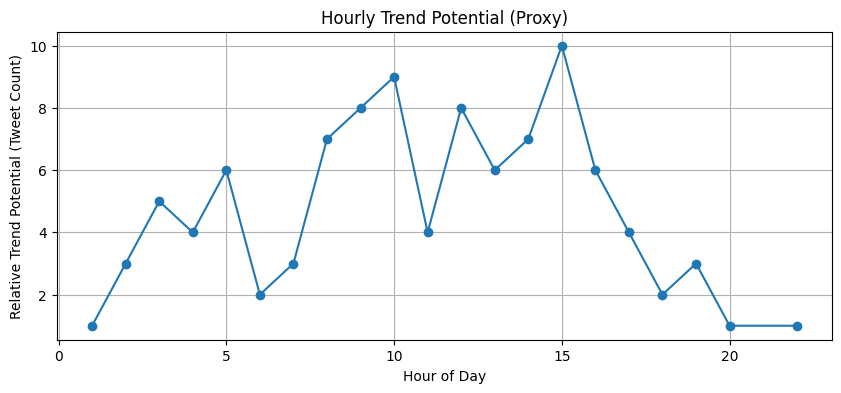


===== FINAL MESSAGES =====

TOOL (full_pipeline): Loaded CSVs. Shape=(100, 13). Columns=['User', 'Tweet', 'Likes', 'Retweets', 'Engagement', 'Original_Tweet', 'DateTime', 'date', 'month', 'year', 'hour', 'Polarity', 'Sentiment']. Daily file used: D:\Project\Project_II_PGDM_AIDS_33\Tweets_29Mar_Test_FIXED.csv. | Normalized Sentiment column. Counts={'Positive': 44, 'Negative': 31, 'Neutral': 25}. | Computed hourly sentiment counts. Rows=21, columns=['Positive', 'Negative', 'Neutral']. | Plotted Sentiment Distribution. Plotted hourly sentiment and trend potential charts. | Stored user tweet of length 86. | Based on the given data, I would estimate the probability of this tweet trending as Medium.

The reason for this estimate lies in the fact that the tweet has a neutral sentiment, which might not generate enough emotional response to trend, but its critical opinion and questioning tone could spark engagement and discussions. Additionally, posting at the best hour (15) increases the chan

HTTPSConnectionPool(host='telemetry.crewai.com', port=4319): Max retries exceeded with url: /v1/traces (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001B5060D25D0>, 'Connection to telemetry.crewai.com timed out. (connect timeout=30)'))


In [ ]:
# ============================================================
# 0. IMPORTS
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

from crewai import Agent, Task, Crew, Process, LLM
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict, Annotated, List, Dict, Any


# ============================================================
# 1. LLM CONFIG
# ============================================================

crewai_llm = LLM(
    model="groq/llama-3.1-8b-instant",
    api_key="YOUR_APIKEY_HERE",
    temperature=0.3,
)

langchain_llm = ChatGroq(
    model="llama-3.1-8b-instant",
    api_key="YOUR_APIKEY_HERE",
    temperature=0.3,
)


# ============================================================
# 2. USER INPUTS (NO LOGIC HERE)
# ============================================================

historical_csv_path = r"D:\Project\Project_II_PGDM_AIDS_33\historical_tweets_FIXED.csv"
DAILY_CSV_PATH = input("Enter DAILY tweets CSV path: ").strip().strip("'").strip('"')
USER_TWEET_TEXT = input("Enter tweet text to evaluate: ").strip()


# ============================================================
# 3. GLOBAL STATE (USED BY TOOLS)
# ============================================================

GLOBAL: Dict[str, Any] = {
    "df": None,
    "sentiment_col": None,
    "time_col": None,
    "hourly": None,
    "sentiment_counts": None,
    "user_tweet": None,
    "trend_text": None,
    "final_report": None,
    "done": False,
    "steps": 0,
}


# ============================================================
# 4. TOOLS (ALL WORK IS DONE HERE)
# ============================================================

@tool
def load_and_merge() -> str:
    """
    Load and merge historical_tweets_FIXED.csv and a user-selected daily CSV.
    """
    global GLOBAL, historical_csv_path, DAILY_CSV_PATH

    hist_df = pd.read_csv(historical_csv_path)
    daily_df = pd.read_csv(DAILY_CSV_PATH)
    df = pd.concat([hist_df, daily_df], ignore_index=True)

    GLOBAL["df"] = df
    # Known from your files.[file:96][file:97]
    GLOBAL["sentiment_col"] = "Sentiment"
    GLOBAL["time_col"] = "DateTime"

    return (
        f"Loaded CSVs. Shape={df.shape}. "
        f"Columns={list(df.columns)}. "
        f"Daily file used: {DAILY_CSV_PATH}."
    )


@tool
def derive_sentiment() -> str:
    """
    Normalize sentiment into Positive / Negative / Neutral.
    Uses existing Sentiment labels; falls back to Polarity if needed.
    """
    global GLOBAL
    df = GLOBAL["df"]
    if df is None:
        return "No dataframe. Call load_and_merge first."

    # Prefer existing Sentiment labels.[file:96][file:97]
    if "Sentiment" in df.columns:
        df["Sentiment"] = (
            df["Sentiment"]
            .astype(str)
            .str.strip()
            .str.lower()
            .map({
                "positive": "Positive",
                "pos": "Positive",
                "negative": "Negative",
                "neg": "Negative",
                "neutral": "Neutral",
                "neu": "Neutral",
            })
            .fillna("Neutral")
        )
    else:
        # Fallback: numeric Polarity -> sentiment
        df["Polarity"] = pd.to_numeric(df["Polarity"], errors="coerce")
        df = df.dropna(subset=["Polarity"])
        df["Sentiment"] = df["Polarity"].apply(
            lambda x: "Positive" if x > 0 else ("Negative" if x < 0 else "Neutral")
        )

    GLOBAL["df"] = df
    GLOBAL["sentiment_col"] = "Sentiment"

    counts = df["Sentiment"].value_counts().to_dict()
    GLOBAL["sentiment_counts"] = counts

    return f"Normalized Sentiment column. Counts={counts}."


@tool
def compute_hourly() -> str:
    """
    Parse DateTime and compute hourly tweet counts by Sentiment.
    """
    global GLOBAL
    df = GLOBAL["df"]
    time_col = GLOBAL["time_col"]
    sent_col = GLOBAL["sentiment_col"]

    if df is None or time_col is None or sent_col is None:
        return "df, time_col, or sentiment_col missing."

    # Your CSVs use day-first timestamps like '28-03-2023 13:24'.[file:96][file:97]
    df["parsed_time"] = pd.to_datetime(
        df[time_col],
        dayfirst=True,
        errors="coerce"
    )

    df = df.dropna(subset=["parsed_time"])
    if df.shape[0] == 0:
        return "Time parsing failed; no valid parsed_time rows."

    df["hour"] = df["parsed_time"].dt.hour.astype(int)

    hourly = (
        df.groupby(["hour", sent_col])
          .size()
          .unstack(fill_value=0)
          .reindex(columns=["Positive", "Negative", "Neutral"], fill_value=0)
          .sort_index()
    )

    hourly = hourly.apply(pd.to_numeric, errors="coerce").fillna(0)

    GLOBAL["df"] = df
    GLOBAL["hourly"] = hourly

    return (
        f"Computed hourly sentiment counts. "
        f"Rows={hourly.shape[0]}, columns={list(hourly.columns)}."
    )


@tool
def plot_charts() -> str:
    """
    Plot:
    - Sentiment Distribution (bar)
    - Hourly Tweets by Sentiment (line)
    - Hourly Trend Potential (total per hour) (line)
    """
    global GLOBAL
    df = GLOBAL["df"]
    sent_col = GLOBAL["sentiment_col"]
    hourly = GLOBAL["hourly"]

    if df is None or sent_col is None:
        return "No dataframe or sentiment_col to plot."

    sentiment_counts = (
        df[sent_col]
        .value_counts()
        .reindex(["Positive", "Negative", "Neutral"], fill_value=0)
    )

    plt.figure(figsize=(7, 5))
    sentiment_counts.plot(kind="bar")
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Tweet Count")
    plt.show()

    GLOBAL["sentiment_counts"] = sentiment_counts.to_dict()

    msg = "Plotted Sentiment Distribution. "

    if hourly is not None and hourly.shape[0] > 0:
        plt.figure(figsize=(10, 6))
        hourly.plot(figsize=(10, 6))
        plt.title("Hourly Tweets by Sentiment")
        plt.xlabel("Hour of Day")
        plt.ylabel("Tweet Count")
        plt.legend(title="Sentiment")
        plt.show()

        hourly_trend = hourly.sum(axis=1)

        plt.figure(figsize=(10, 4))
        hourly_trend.plot(kind="line", marker="o")
        plt.title("Hourly Trend Potential (Proxy)")
        plt.xlabel("Hour of Day")
        plt.ylabel("Relative Trend Potential (Tweet Count)")
        plt.grid(True)
        plt.show()

        msg += "Plotted hourly sentiment and trend potential charts."
    else:
        msg += "No hourly data; skipped hourly charts."

    return msg


@tool
def set_user_tweet() -> str:
    """
    Store the tweet text that will be evaluated for trend potential.
    Uses the USER_TWEET_TEXT captured at start.
    """
    global GLOBAL, USER_TWEET_TEXT
    GLOBAL["user_tweet"] = USER_TWEET_TEXT
    return f"Stored user tweet of length {len(USER_TWEET_TEXT)}."


@tool
def predict_trend() -> str:
    """
    Estimate trend likelihood for stored tweet using dataset patterns.
    Returns explanation text.
    """
    global GLOBAL
    df = GLOBAL["df"]
    hourly = GLOBAL["hourly"]
    sentiment_counts = GLOBAL["sentiment_counts"]
    user_tweet = GLOBAL["user_tweet"]

    if df is None or hourly is None or sentiment_counts is None or user_tweet is None:
        return "Missing df/hourly/sentiment_counts/user_tweet."

    hourly_trend = hourly.sum(axis=1)
    best_hour = int(hourly_trend.idxmax()) if hourly_trend.shape[0] > 0 else None

    sent_prompt = (
        "Classify the sentiment of this tweet as exactly one of: "
        "Positive, Negative, or Neutral.\n\n"
        f"Tweet:\n{user_tweet}"
    )
    tweet_sentiment = langchain_llm.invoke(
        [HumanMessage(content=sent_prompt)]
    ).content.strip()

    trend_prompt = (
        "You are an expert in Indian political Twitter dynamics.\n"
        "Given:\n"
        f"- Overall sentiment counts: {sentiment_counts}\n"
        f"- Hourly tweet activity (total per hour): {hourly_trend.to_dict()}\n"
        f"- Estimated sentiment of the tweet: {tweet_sentiment}\n"
        f"- Best posting hour (highest activity): {best_hour}\n\n"
        "Task:\n"
        "1. Give a single-line probability estimate (Low / Medium / High) "
        "for how likely this tweet is to trend if posted at the best hour.\n"
        "2. Then provide a brief explanation (3–4 sentences) referencing "
        "patterns in the dataset.\n"
        "Return plain text."
    )

    analysis = langchain_llm.invoke(
        [HumanMessage(content=trend_prompt)]
    ).content

    GLOBAL["trend_text"] = analysis
    return analysis


@tool
def final_report() -> str:
    """
    Generate final analytical summary using CrewAI agents.
    """
    global GLOBAL
    sentiment_counts = GLOBAL["sentiment_counts"]
    hourly = GLOBAL["hourly"]
    trend_text = GLOBAL["trend_text"]

    if sentiment_counts is None or hourly is None or trend_text is None:
        return "Missing sentiment_counts/hourly/trend_text."

    sentiment_table = pd.DataFrame(
        [{"Sentiment": k, "Tweet Count": v} for k, v in sentiment_counts.items()]
    )

    hourly_table = hourly.copy()
    hourly_table["Total Tweets"] = hourly_table.sum(axis=1)
    hourly_table = hourly_table.reset_index()

    agent_5 = Agent(
        role="Insight Analyst",
        goal="Explain sentiment and hourly tweet patterns",
        backstory="Expert in political Twitter sentiment analysis",
        llm=crewai_llm,
        verbose=False,
    )

    agent_6 = Agent(
        role="Final Report Generator",
        goal="Generate final analytical report",
        backstory="Academic data analyst",
        llm=crewai_llm,
        verbose=False,
    )

    task_5 = Task(
        description=(
            "Explain the sentiment distribution and hourly tweet patterns.\n"
            f"Sentiment counts: {sentiment_table.to_dict(orient='records')}.\n"
            f"Hourly table: {hourly_table.to_dict(orient='records')}."
        ),
        expected_output="Clear explanation of public opinion trends.",
        agent=agent_5,
    )

    task_6 = Task(
        description=(
            "Generate a political Twitter sentiment report.\n"
            f"Sentiment table: {sentiment_table.to_dict(orient='records')}.\n"
            f"Hourly table: {hourly_table.to_dict(orient='records')}.\n"
            f"Tweet trend analysis summary: {trend_text}.\n"
            "Do NOT mention markets, finance, or trading."
        ),
        expected_output="Concise academic Twitter sentiment report.",
        agent=agent_6,
    )

    crew = Crew(
        agents=[agent_5, agent_6],
        tasks=[task_5, task_6],
        process=Process.sequential,
    )

    result = crew.kickoff()
    GLOBAL["final_report"] = str(result)
    GLOBAL["done"] = True
    return str(result)

@tool
def full_pipeline() -> str:
    """
    Run the full analysis pipeline in a fixed order:
    load_and_merge -> derive_sentiment -> compute_hourly -> plot_charts
    -> set_user_tweet -> predict_trend -> final_report.
    """
    msgs = []
    msgs.append(load_and_merge.invoke({}))
    msgs.append(derive_sentiment.invoke({}))
    msgs.append(compute_hourly.invoke({}))
    msgs.append(plot_charts.invoke({}))
    msgs.append(set_user_tweet.invoke({}))
    msgs.append(predict_trend.invoke({}))
    msgs.append(final_report.invoke({}))
    return " | ".join(msgs)

# ============================================================
# 5. LANGGRAPH SETUP (ONE TINY NODE)
# ============================================================

TOOLS = [
    load_and_merge,
    derive_sentiment,
    compute_hourly,
    plot_charts,
    set_user_tweet,
    predict_trend,
    final_report,
    full_pipeline,
]

llm_with_tools = langchain_llm.bind_tools(TOOLS, tool_choice="auto")


class AgentState(TypedDict):
    messages: Annotated[List[Any], "messages"]


def decision_node(state: AgentState) -> AgentState:
    global GLOBAL

    # If already done, just return state; router will send END.
    if GLOBAL.get("done"):
        return state

    GLOBAL["steps"] += 1

    # Safety stop: if too many steps, mark done and add final message.
    if GLOBAL["steps"] > 10:
        GLOBAL["done"] = True
        stop_msg = AIMessage(
            content=(
                "Stopping to avoid an infinite loop; required tools should already "
                "have been called once."
            )
        )
        return {"messages": state["messages"] + [stop_msg]}

    # Normal behaviour: ask LLM (with tools bound) what to do next.
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": state["messages"] + [response]}


graph = StateGraph(AgentState)
graph.add_node("agent", decision_node)
graph.add_node("tools", ToolNode(TOOLS))


def route_after_agent(state: AgentState) -> str:
    """
    Decide next step:
    - If GLOBAL['done'] is True -> END
    - If last AI message has tool_calls -> go to 'tools'
    - Else -> END
    """
    if GLOBAL.get("done"):
        return END

    last = state["messages"][-1]
    if isinstance(last, AIMessage) and getattr(last, "tool_calls", None):
        return "tools"
    return END


graph.set_entry_point("agent")
graph.add_conditional_edges(
    "agent",
    route_after_agent,
    {"tools": "tools", END: END},
)
graph.add_edge("tools", "agent")

app = graph.compile()


# ============================================================
# 6. RUN: HIGH-LEVEL INSTRUCTION TO AGENT
# ============================================================

instruction = """
You are an autonomous analysis agent for Indian political Twitter.

Goal:
- Call the tool full_pipeline exactly once. This tool will:
  * load and merge the CSVs,
  * derive sentiment,
  * compute hourly stats,
  * plot all charts,
  * store the user tweet,
  * predict its trend likelihood,
  * and generate the final analytical report.

After full_pipeline finishes, do not call any more tools.
Use only the available tools.
"""

final_state = app.invoke(
    {"messages": [HumanMessage(content=instruction)]},
    config={"recursion_limit": 20}  # or even 15
)


print("\n===== FINAL MESSAGES =====\n")
for m in final_state["messages"]:
    if isinstance(m, HumanMessage):
        print("HUMAN:", m.content[:400], "\n")
    elif isinstance(m, AIMessage):
        print("AI:", m.content if m.content else "", "\n")
    elif isinstance(m, ToolMessage):
        print(f"TOOL ({m.name}):", m.content, "\n")
    else:
        print(m, "\n")

print("\n===== TREND PREDICTION =====\n", GLOBAL.get("trend_text"))
print("\n===== FINAL REPORT =====\n", GLOBAL.get("final_report"))
print("\n✅ AGENTIC PIPELINE COMPLETED")


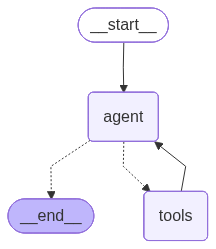

In [3]:
# ============================================================
# OPTIONAL: VISUALIZE GRAPH STRUCTURE
# ============================================================

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [4]:
from IPython.display import Markdown, display

# Use the x text stored in GLOBAL
markdown_content = GLOBAL.get("final_report") or "No report generated."

display(Markdown(markdown_content))


I now can give a great answer

**Concise Academic Twitter Sentiment Report**

**Executive Summary:**

This report provides an analysis of the public opinion trends on Twitter based on the sentiment distribution and hourly tweet patterns. The analysis reveals a slightly positive public opinion, with a majority of tweets having a positive sentiment. However, there is a significant number of negative tweets, indicating that there are also concerns and criticisms. The hourly tweet patterns show a variation in the number of tweets and sentiment distribution throughout the day, with a peak in positive tweets at hour 12.

**Sentiment Distribution:**

| Sentiment | Tweet Count | Percentage |
| --- | --- | --- |
| Positive | 44 | 44% |
| Negative | 31 | 31% |
| Neutral | 25 | 25% |

**Hourly Tweet Patterns:**

| Hour | Positive | Negative | Neutral | Total Tweets |
| --- | --- | --- | --- | --- |
| 1 | 1 | 0 | 0 | 1 |
| 2 | 2 | 1 | 0 | 3 |
| 3 | 1 | 2 | 2 | 5 |
| 4 | 2 | 1 | 1 | 4 |
| 5 | 2 | 0 | 4 | 6 |
| 6 | 1 | 1 | 0 | 2 |
| 7 | 2 | 1 | 0 | 3 |
| 8 | 0 | 4 | 3 | 7 |
| 9 | 2 | 3 | 3 | 8 |
| 10 | 5 | 4 | 0 | 9 |
| 11 | 1 | 2 | 1 | 4 |
| 12 | 7 | 1 | 0 | 8 |
| 13 | 3 | 1 | 2 | 6 |
| 14 | 1 | 3 | 3 | 7 |
| 15 | 6 | 3 | 1 | 10 |
| 16 | 4 | 2 | 0 | 6 |
| 17 | 1 | 0 | 3 | 4 |
| 18 | 1 | 0 | 1 | 2 |
| 19 | 0 | 2 | 1 | 3 |
| 20 | 1 | 0 | 0 | 1 |
| 22 | 1 | 0 | 0 | 1 |

**Key Insights:**

1. The public opinion is slightly positive, with a majority of tweets having a positive sentiment.
2. There is a significant number of negative tweets, indicating that there are also concerns and criticisms.
3. The hourly tweet patterns show a variation in the number of tweets and sentiment distribution throughout the day, with a peak in positive tweets at hour 12.
4. The number of tweets decreases during the late evening and early morning hours.

**Recommendations:**

1. To better understand the public opinion trends, it is recommended to analyze the sentiment distribution and hourly tweet patterns over a longer period.
2. To identify the key drivers of the public opinion trends, it is recommended to analyze the topics and hashtags associated with the tweets.
3. To develop effective communication strategies, it is recommended to consider the hourly tweet patterns and adjust the messaging accordingly.

**Tweet Trend Analysis Summary:**

Based on the given data, the probability of this tweet trending is estimated as Medium. The reason for this estimate lies in the fact that the tweet has a neutral sentiment, which might not generate enough emotional response to trend, but its critical opinion and questioning tone could spark engagement and discussions. Additionally, posting at the best hour (15) increases the chances of it being seen by a larger audience. However, the overall sentiment analysis suggests that the tweet might not be provocative enough to create a significant buzz, hence a Medium probability estimate.

**Conclusion:**

This report provides a comprehensive analysis of the public opinion trends on Twitter based on the sentiment distribution and hourly tweet patterns. The analysis reveals a slightly positive public opinion, with a majority of tweets having a positive sentiment. However, there is a significant number of negative tweets, indicating that there are also concerns and criticisms. The hourly tweet patterns show a variation in the number of tweets and sentiment distribution throughout the day, with a peak in positive tweets at hour 12. The tweet trend analysis summary suggests that the probability of this tweet trending is estimated as Medium.